In [1]:
%matplotlib widget

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/03 19:19:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


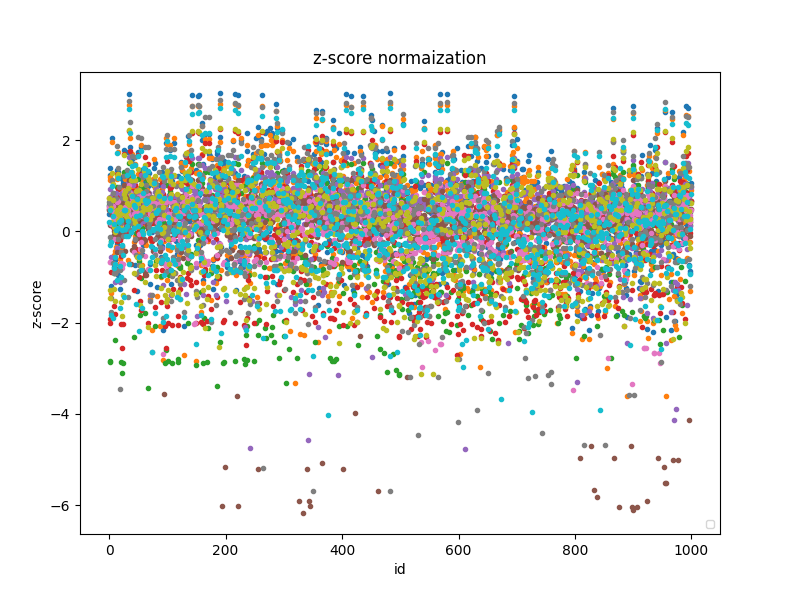

,id,id_job,feature_type_1_0_stand,feature_type_1_1_stand,feature_type_1_2_stand,feature_type_1_3_stand,feature_type_1_4_stand,feature_type_1_5_stand,feature_type_1_6_stand,feature_type_1_7_stand,feature_type_1_8_stand,feature_type_1_9_stand
0,0,-68888894506869945631,0.390617,0.727857,0.589099,0.488138,0.552816,0.476617,0.536111,0.636679,0.738897,0.210220
1,1,-45528547052692089371,1.244735,1.184115,-2.834308,-2.005010,0.748541,0.148144,-0.675595,-0.120870,-1.291557,-0.288599
2,2,33899130356965745151,1.382021,1.118533,-2.864514,-1.917006,0.937487,0.176908,-0.679913,0.603182,-1.462419,0.473127
3,3,-1697736982326412151,0.411210,0.495513,-0.200144,-0.889081,-0.552055,0.438574,0.156137,-1.763515,0.210943,-1.830828
4,4,-53991638443464865861,-1.199943,-1.351066,0.582128,0.535315,0.135947,0.476617,0.480518,-1.450446,0.511081,-0.234609
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,-55382527010294823101,-0.744937,-0.227754,0.229719,0.014549,0.248637,0.208457,0.225223,-0.602713,-0.255537,-0.754554
996,996,-38269269630739291871,0.630868,1.319961,0.496930,0.654166,0.753624,-4.125724,0.438419,1.414841,0.457744,1.170299
997,997,91717453934891372711,-0.860650,-1.313591,0.417928,-0.026278,0.113070,0.197322,0.367174,-1.197930,0.277841,-0.932955
998,998,-15903689633302548341,-0.900855,-0.241807,0.139099,0.288541,0.252026,-0.097747,0.216587,0.640544,-0.355885,0.059988


In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import stddev, mean, col, udf, lit
from pyspark.sql.types import FloatType
from IPython.display import display
import matplotlib.pyplot as plot
import pandas as pandas


# Define function to compute Z-score
def z_score(x: int, mean: int, stddev: int) -> int:    
    try:
        z_score = (x - mean) / stddev
    except ZeroDivisionError as e:
        raise(e)
    else:
        return z_score

# Convert function which compute Z-score into UDF
z_score_udf = udf(z_score, FloatType())


def normalize_df_z_score(train_df: DataFrame, test_df: DataFrame, cols_names: list[str], cols_new_name_function : callable = lambda col_new_name : col_new_name) -> DataFrame:
    """
    Transform data in CSV format by computing the Z-score standardization for each value in selected columns.
    
    Parameters:
        train_df (DataFrame): input DataFrame with train data.
        test_df (DataFrame): input DataFrame with tested data.
        columns_suffix (str): Column header's suffix which will be concat with original column name to create new column name for resulting values
    """

    # Iterate over feature_type_1_{i} columns and perform z-standardization for each value in a feature column
    for col_name in cols_names:
        mean_val = lit(train_df.select(mean(col_name)).collect()[0][0])
        stddev_val = lit(train_df.select(stddev(col_name)).collect()[0][0])

        new_col_name = cols_new_name_function(col_name)

        test_df = test_df.withColumn(col_name, z_score_udf(col(col_name), mean_val, stddev_val))\
                         .withColumnRenamed(col_name, new_col_name)

    return test_df


def pandas_plot_single(pandas_dataframe: pandas.DataFrame, y_axs: list, x_axs: list, title: str = "") -> None:
    # Build the scatter plot
    plot.scatter(y_axs, x_axs)
    plot.xlabel(y_axs)
    plot.ylabel(x_axs)
    plot.title(title)


def pandas_plot_figure(pandas_dataframe: pandas.DataFrame, col_names: list[str], axs_col_name: str, tittle : str = "") -> None:
    x_axs = pandas_dataframe[axs_col_name].tolist()
    
    fig, ax = plot.subplots() # Create a matplotlib figure
    for col_name in col_names:
        ax.plot(x_axs, pandas_dataframe[col_name].tolist(), label=col_name)# Set title and labels
    
    ax.set_xlabel(axs_col_name)
    ax.set_ylabel('score')# Add a legend
    ax.legend(loc='lower center', bbox_to_anchor=(1.25, 0.5), ncol=3)
    ax.set_title(tittle)
    
    
# Build the scatter plot with multiple functions
def pandas_plot_scatter(pandas_dataframe: pandas.DataFrame, col_names: list[str], axs_col_name: str, tittle : str = "") -> None:
    plot.subplots(figsize=(8, 6))
    plot.subplots_adjust(left=0.1)
    plot.title(tittle)
    plot.xlabel(axs_col_name)
    plot.ylabel("z-score")
    plot.legend(loc='lower right', fontsize=8)
    x_axs = pandas_dataframe[axs_col_name].tolist()
    
    for column in col_names:
        plot.scatter(x_axs, pandas_dataframe[column].tolist(), label=column, s=9)
    
    


if __name__ == "__main__":
    output_data_path = "../data/output/test_transformed.csv"

    conf = SparkConf().setAppName("score-standardization-spark")
    sc = SparkContext(conf=conf)
    sc.setLogLevel("WARN")
    
    spark = SparkSession.builder.appName("score-standardization-spark").getOrCreate()

    # Load *.csv
    train_df = spark.read.csv("../data/input/train.csv", header=True, inferSchema=True)
    test_df = spark.read.csv("../data/input/test.csv", header=True, inferSchema=True)

    # Filter column headers which starts with `feature_type_1`
    feature_cols = list(filter(lambda header: header.startswith("feature_type_1_"), test_df.columns))

    normalized_df = normalize_df_z_score(test_df, train_df, feature_cols, cols_new_name_function=lambda col_name : col_name + "_stand")

#     normalized_df.coalesce(1).write.option("header",True).csv(output_data_path)
    
    normalized_df_pandas = normalized_df.toPandas()
    
    # Filter column headers `feature_type_1_{i}_stand`
    normalized_feature_cols = list(filter(lambda header: header.startswith("feature_type_1_"), normalized_df_pandas.columns))
    
    pandas_plot_scatter(normalized_df_pandas, axs_col_name="id", col_names=normalized_feature_cols, tittle="z-score normaization")
    plot.show()
    
    display(normalized_df_pandas)
    
    spark.stop()
